In [56]:
# Enter the Python code you need in this cell.
# Importing the required method.
from ragraph.io.csv import from_csv
from ragraph.graph import Edge 
# Converting csv files into a graph object.
g = from_csv(
    nodes_path="./nodes-components.csv",
    edges_path="./edges-nodes-components.csv",
    csv_delimiter=";",
    iter_delimiter=",",  # Separates list elements within a cell.
)

reverted_edges = []
for e in g.edges:
    reverted_edges.append(
        Edge(
            source=e.target,
            target=e.source,
            kind=e.kind,
            labels=e.labels,
            weights=e.weights,
            annotations=e.annotations
        )
    )

for e in reverted_edges:
    g.add_edge(e)

components = [n for n in g.nodes if n.kind == "component"]

for ci in components:
    for cj in components:
        if ci == cj:
            continue

        targets_ci = set([t for t in g.targets_of(ci) if t.kind == "node"])
        targets_cj = set([t for t in g.targets_of(cj) if t.kind == "node"])

        # Note: when cycling home I realized you should use the Jaccard index. 
        # Number of nodes in which ci and cj
        n_common_nodes = len(targets_ci.intersection(targets_cj))
        # Number of nodes in which ci and/or cj is applied. 
        n_total_nodes = len(targets_ci.union(targets_cj))

        if n_total_nodes:
            jaccard_index = n_common_nodes / n_total_nodes 
        else:
            jaccard_index = 0
            
        if jaccard_index > 0:
            g.add_edge(
                Edge(
                    source=ci,
                    target=cj,
                    weights={"jaccard_index": jaccard_index}
                )
            )
teams = [n for n in g.nodes if n.kind == "team"]
_exhausted = object()
for ti in teams:
    for tj in teams:
        if ti == tj:
            continue
        targets_ti = set([t for t in g.targets_of(ti) if t.kind == "component"])
        targets_tj = set([t for t in g.targets_of(tj) if t.kind == "component"])

        combined_weight = 0
        for tti in targets_ti:
            for ttj in targets_tj:
                edge_find = g.edges_between(tti,ttj)
                edge1 = next(edge_find,0)
                if edge1 == 0:
                    continue
                weights1 = edge1.weights
                weight = weights1["jaccard_index"]
                combined_weight = combined_weight+weight
                
        n_total_nodes = len(targets_ti.union(targets_tj))
        if n_total_nodes:
            combined_index = combined_weight / n_total_nodes 
        else:
            combined_index = 0
        if combined_index > 0:    
            g.add_edge(
                Edge(
                    source = ti,
                    target = tj,
                    weights ={"combined_weights": combined_index}
                )
            )
                
print(edge_find)  
print(edge1)
print(weight)
print(type(weight))

<generator object Graph.edges_between at 0x7f3bcab21250>
Edge(source='ancillary-vibration-attenuator', target='TM-interfaces-ears', name='64fe40d9-3fac-4b47-a3e9-46ee5309ca08')
0.25
<class 'float'>


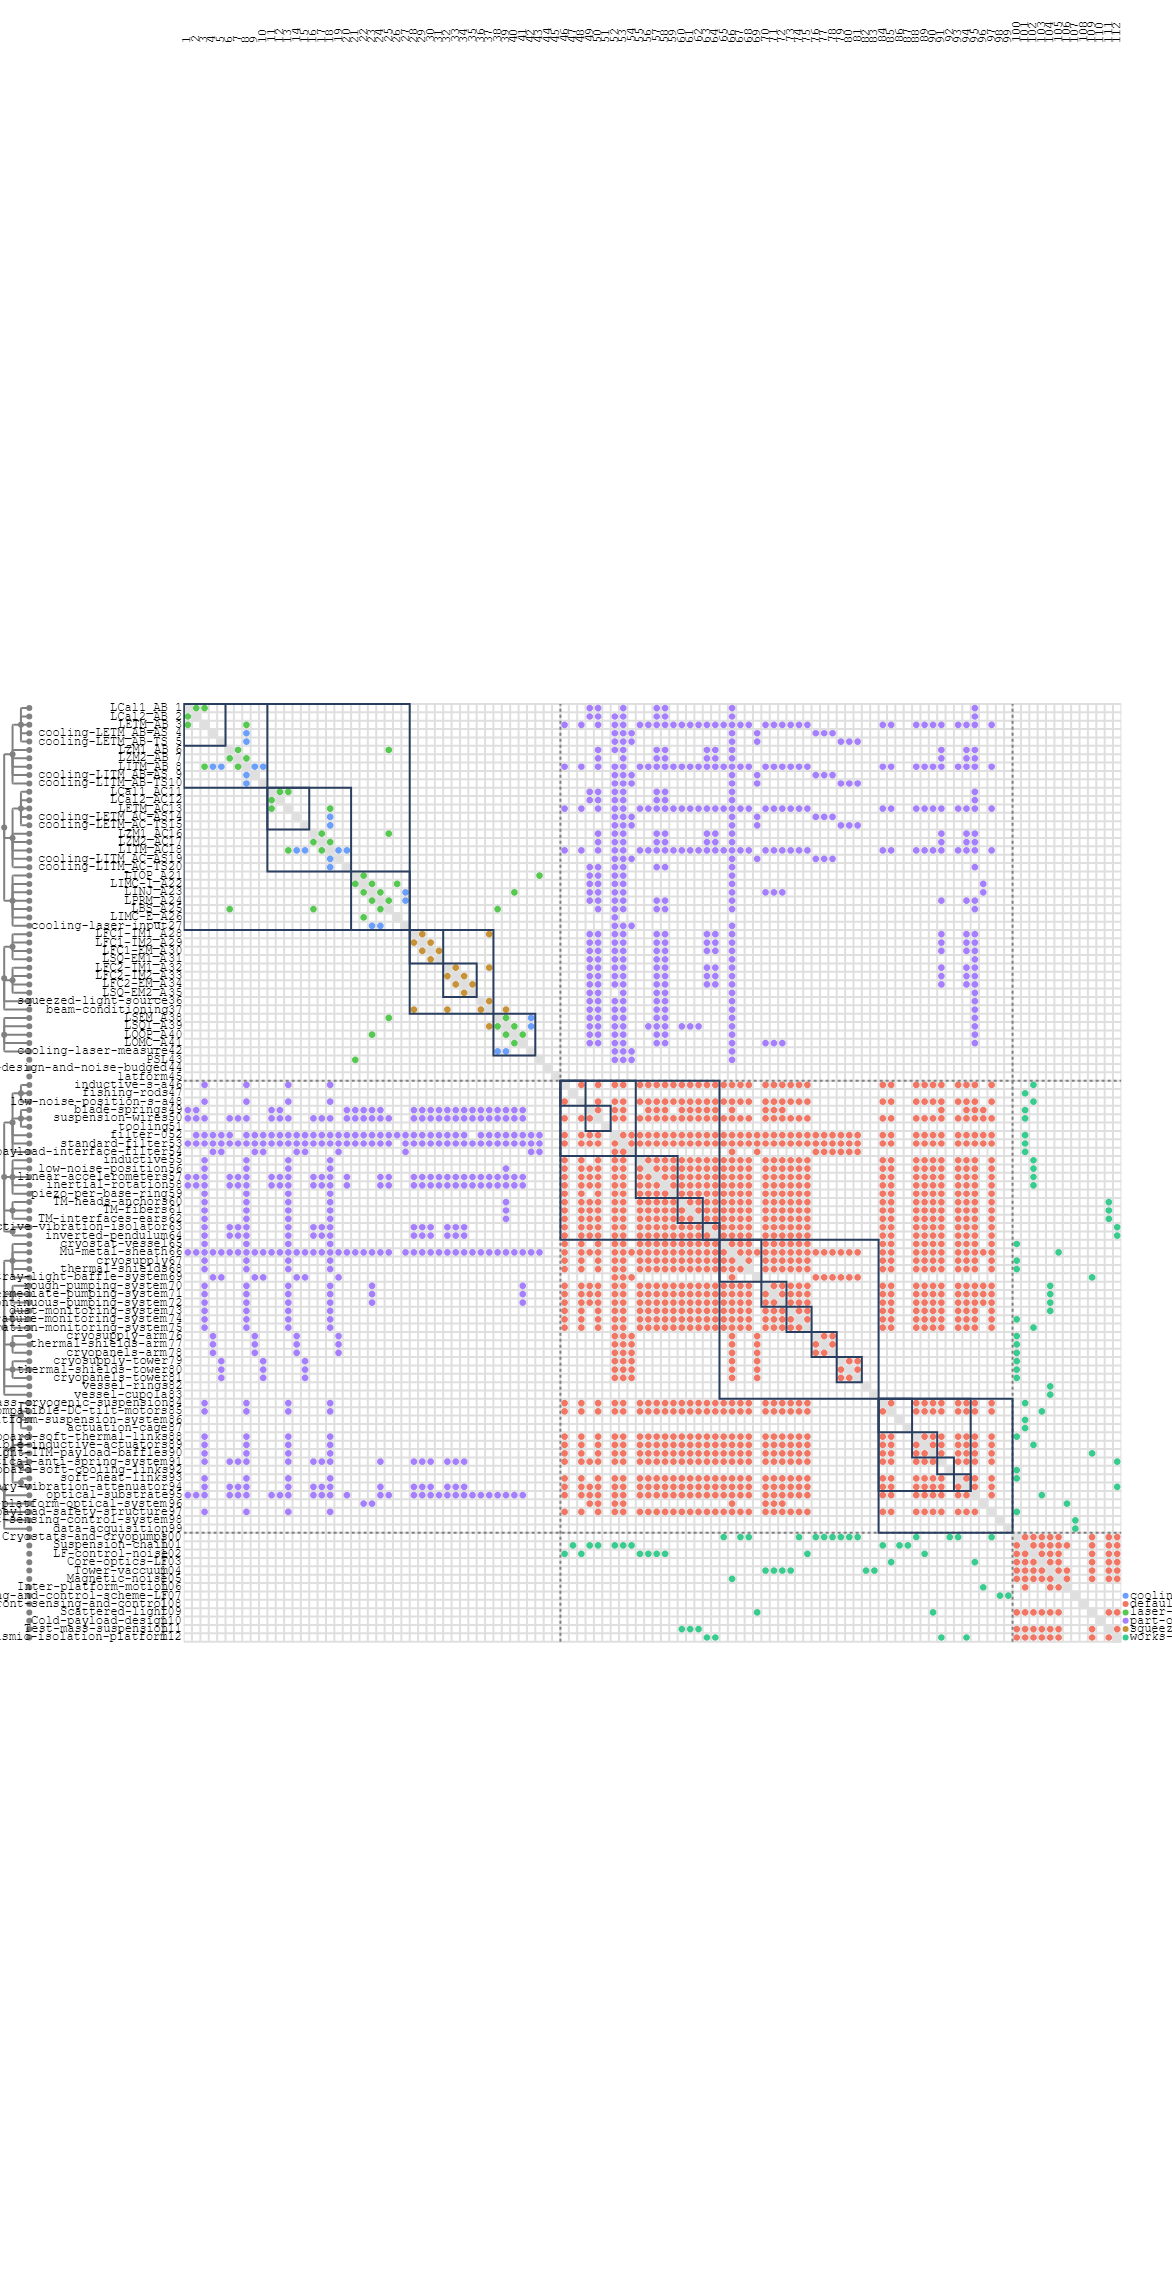

In [57]:
import ragraph.plot

dsm = ragraph.plot.mdm(
    leafs = g.nodes,
    edges = g.edges,
    style= ragraph.plot.Style(
        piemap=dict(
            display="labels",
            mode="relative",
            fields=g.edge_labels
        ),
    )
)

dsm

In [58]:
g.node_kinds
g.edge_weight_labels

['combined_weights', 'default', 'jaccard_index']

In [59]:
import ragraph.plot

mdm = ragraph.plot.mdm(
    leafs = g.nodes,
    edges = g.edges,
    style= ragraph.plot.Style(
        piemap=dict(
            display="weights",
            mode="relative",
            fields=g.edge_weight_labels
        ),
    )
)


mdm.write_image("./mdm_weighted_and_unclustered.svg")
#mdm.write_html("./mdm_weighted_and_unclustered.html")
#mdm

In [60]:
from ragraph.analysis.heuristics import markov_gamma 

markov_gamma(
    g,
    leafs=[n for n in g.nodes if n.kind == "component" and n.is_leaf],
    beta=8.0,
    mu=8.0,
    gamma=3.0,
    edge_weights=["jaccard_index"]
)

# recluster the components part of cluster "component.node0". You can however over the tree in the HTML to obtain the names of clusters.
markov_gamma(
    g,
    root=g["component.node0"],
    beta=6.0,
    mu=6.0,
    gamma=3.0,
    edge_weights=["jaccard_index"]
)

mdm = ragraph.plot.mdm(
    leafs = g.nodes,
    edges = g.edges,
    style= ragraph.plot.Style(
        piemap=dict(
            display="weights",
            mode="relative",
            fields=g.edge_weight_labels
        ),
    )
)


mdm.write_image("./mdm_weighted_and_clustered.svg")
#mdm.write_html("./mdm_weighted_and_clustered.html") 